In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
max_limit = 30
budget_diff_penalizer = 1

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

data = {}
paths = ["results/powell_hubo_results", 
         "results/slsqp_hubo_results", 
         "results/cobyla_hubo_results", 
         "results/cmaes_hubo_results",
         "results/nelder_mead_hubo_results",
         "results/lbfgsb_hubo_results"]
# Get file names like portfolio_optimization_results_batch_ from the parent directory
for path in paths:
    files = [file for file in os.listdir("../" + path) if "portfolio_optimization_results_batch_" in file]
    method = path.split("/")[-1].split("_")[0]
    data[method] = {}
    for file in files:
        data[method].update(load_json("../" + path + "/" + file))

print(f"Loaded {len(data)} cases.")

# For each method, get the number of evaluations and the "final_expectation_value" grouped by qubits
stats = {}
for case in range(0, 100):
    if case not in stats:
        stats[case] = {}
    for method, results in data.items():
        case_id = str(case)
        if method not in stats[case]:
            stats[case][method] = {}
        if case_id in results:
            value = results[case_id]
            stats[case]["qubits"] = value["hyperparams"]["n_qubits"]
            stats[case][method]["expectation_values"] = value["qaoa_solution"]["final_expectation_value"]
            stats[case][method]["evaluations"] = value["qaoa_solution"]["training_history"]["evaluations"]

#print(json.dumps(stats, indent=4))


Loaded 6 cases.


[
    {
        "case_id": 0,
        "method": "powell",
        "qubits": 10,
        "expectation_value": -0.23661978876003018
    },
    {
        "case_id": 0,
        "method": "slsqp",
        "qubits": 10,
        "expectation_value": -0.24105815264509511
    },
    {
        "case_id": 0,
        "method": "cobyla",
        "qubits": 10,
        "expectation_value": -0.2292360464603019
    },
    {
        "case_id": 0,
        "method": "cmaes",
        "qubits": 10,
        "expectation_value": -0.23886974599134733
    },
    {
        "case_id": 0,
        "method": "nelder",
        "qubits": 10,
        "expectation_value": -0.23250880772135957
    },
    {
        "case_id": 0,
        "method": "lbfgsb",
        "qubits": 10,
        "expectation_value": -0.23682236109773208
    },
    {
        "case_id": 1,
        "method": "powell",
        "qubits": 10,
        "expectation_value": -0.27797844665140686
    },
    {
        "case_id": 1,
        "method": "slsqp",
 

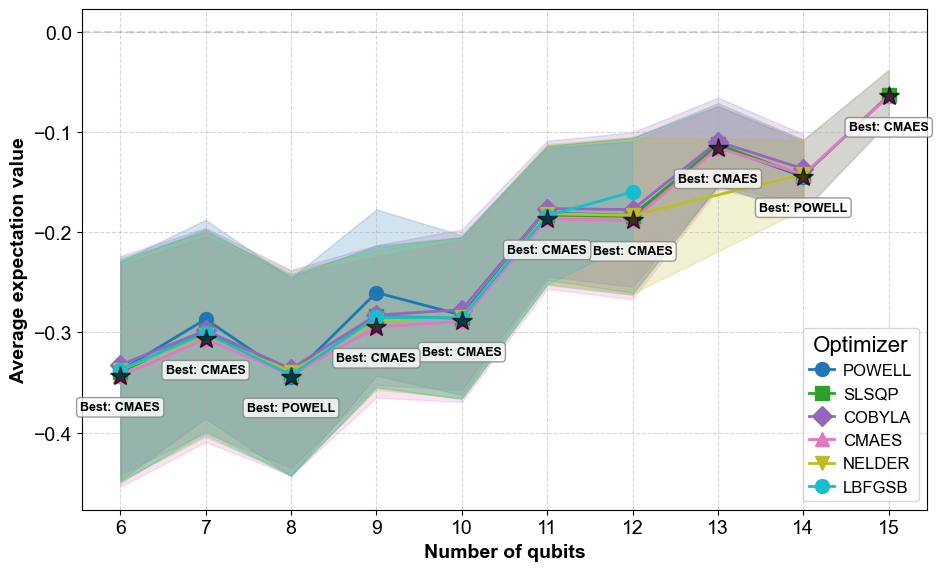

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set publication-quality parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 16,
    'axes.linewidth': 0.8,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.frameon': False,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5
})

# Create a DataFrame for easier manipulation
cases_data = []
for case_id, case_data in stats.items():
    qubits = case_data.get('qubits', 0)
    for method, method_data in case_data.items():
        if method != 'qubits' and method_data:  # Skip the qubits entry and empty data
            if 'expectation_values' in method_data:
                cases_data.append({
                    'case_id': int(case_id),
                    'method': method,
                    'qubits': qubits,
                    'expectation_value': method_data['expectation_values']
                })
print(json.dumps(cases_data, indent=4))
df = pd.DataFrame(cases_data)

# Set up figure with larger size for better readability
fig_height = 6
fig_width = 1.618 * fig_height
plt.figure(figsize=(fig_width, fig_height))

# Colors for methods
methods = df['method'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
color_dict = {method: colors[i] for i, method in enumerate(methods)}
markers = ['o', 's', 'D', '^', 'v']
marker_dict = {method: markers[i % len(markers)] for i, method in enumerate(methods)}

# Group by qubits and method to calculate statistics
grouped_stats = df.groupby(['qubits', 'method'])['expectation_value'].agg(['mean', 'std', 'count']).reset_index()

print(grouped_stats)

# Calculate confidence intervals (95%)
grouped_stats['ci_low'] = grouped_stats.apply(
    lambda x: x['mean'] - 1.96 * x['std'] / np.sqrt(x['count']) if x['count'] > 1 else x['mean'], 
    axis=1
)
grouped_stats['ci_high'] = grouped_stats.apply(
    lambda x: x['mean'] + 1.96 * x['std'] / np.sqrt(x['count']) if x['count'] > 1 else x['mean'], 
    axis=1
)

# Plot each method separately
for method in methods:
    method_data = grouped_stats[grouped_stats['method'] == method]
    method_data = method_data[method_data['count'] > 8]
    if not method_data.empty:
        # Plot the mean line
        plt.plot(method_data['qubits'], method_data['mean'], 
                marker=marker_dict[method], linestyle='-', 
                color=color_dict[method], label=method.upper(),
                linewidth=2, markersize=10)
        
        # Add confidence interval as shaded area
        plt.fill_between(
            method_data['qubits'],
            method_data['ci_low'],
            method_data['ci_high'],
            color=color_dict[method],
            alpha=0.2
        )

# Enhance the plot
#plt.title('Average Optimizer Performance by Qubit Count', fontsize=16, fontweight='bold')
plt.xlabel('Number of qubits', fontsize=14, fontweight='bold')
plt.ylabel('Average expectation value', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Add legend in a good position
plt.legend(title='Optimizer', loc='best', frameon=True, fontsize=12)

# Mark the best performing method at each qubit count
for qubit in df['qubits'].unique():
    qubit_data = grouped_stats[grouped_stats['qubits'] == qubit]
    qubit_data = qubit_data[qubit_data['count'] > 8]
    if not qubit_data.empty:
        best_idx = qubit_data['mean'].idxmin()  # Lower is better for expectation values
        best_method = qubit_data.loc[best_idx, 'method']
        best_value = qubit_data.loc[best_idx, 'mean']
        
        # Add star marker for best performer
        plt.plot(qubit, best_value, '*', color='black', markersize=15, alpha=0.7)
        
        # Add annotation
        plt.annotate(f"Best: {best_method.upper()}", 
                     xy=(qubit, best_value),
                     xytext=(0, -18),
                     textcoords="offset points",
                     ha='center', va='top',
                     fontsize=9, fontweight='bold',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Adjust the plot
plt.tight_layout()

# Make sure qubit counts are integers on x-axis
qubit_counts = sorted(df['qubits'].unique())
plt.xticks(qubit_counts)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

# Add a text box with explanation of the confidence intervals
#plt.figtext(0.5, 0.01, 
#            "Note: Shaded areas represent 95% confidence intervals around the mean.", 
#            ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.savefig('average_expectation_value_by_qubit_count.png', dpi=300)

# Optional: Print a summary table of average performance by method
print("Summary of average expectation values by optimizer:")
summary = df.groupby('method')['expectation_value'].agg(['mean', 'std', 'count']).reset_index()
summary = summary.sort_values('mean')  # Sort by mean expectation value (lower is better)
print(summary)